Using /tmp/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/torch_extensions/gp_interp_cuda/build.ninja...
Building extension module gp_interp_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gp_interp_cuda...
Num coords: 4
Doing a forward pass...
Doing a backward pass...
Loss: 0.12815387547016144
Success!


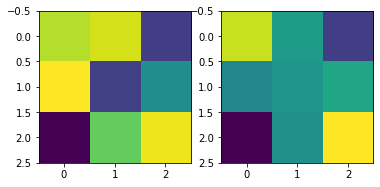

In [1]:
from torch.utils.cpp_extension import load

gp_interp_cuda = load('gp_interp_cuda', ['gp_interp_cuda.cpp', 'gp_interp_cuda_kernel.cu'], verbose=True)

import sys; sys.path.extend(['.', '../cuda'])

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TVF

from gp_interp import GPInterp

device = 'cuda'
# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
# img_pil = Image.open('./water.jpg')
# img = TVF.to_tensor(img_pil).to(device)
size = 3
img = torch.linspace(1, 0, size).view(-1, 1).repeat(1, size).unsqueeze(2).to(device).permute(2, 0, 1)
torch.manual_seed(42)
img = torch.rand_like(img.cpu()).to(img.device)
gp = GPInterp(img.shape[1], img.shape[2], 0.8, 1.0, 1)
# gp.means = nn.Parameter(torch.tensor([[1.0, 1.0]]))
gp.to(device)

print('Num coords:', len(gp.means))

print('Doing a forward pass...')
out = gp(img)

print('Doing a backward pass...')
loss = (out - img).abs().mean()
loss.backward()
print('Loss:', loss.item())
print('Success!')

# TVF.to_pil_image(out.cpu())
plt.subplot(121)
plt.imshow(img[0].detach().cpu())

plt.subplot(122)
plt.imshow(out[0].detach().cpu())

In [2]:
gp.means.grad

tensor([[-0.1840, -0.1927],
        [ 0.0133,  0.0353],
        [-0.0679, -0.0196],
        [-0.0719, -0.1241]], device='cuda:0')

In [3]:
tqdm._instances.clear()

NameError: name 'tqdm' is not defined

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
img_pil = Image.open('./water.jpg')
img = TVF.to_tensor(img_pil).to(device)
gp = GPInterp(img.shape[1], img.shape[2], 0.2, 2.0, 5)
gp.to(device)
out = gp(img)


img_np = np.array(TVF.to_pil_image(out.cpu()))

plt.imshow(img_np)
plt.scatter(gp.means.grid)
TVF.to_pil_image(out.cpu())

In [204]:
from tqdm import tqdm

# img_pil = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')
img_pil = Image.open('./room.jpg')
img = TVF.to_tensor(img_pil).to(device)

initial_losses = []
final_losses = []
diffs_passed = []
stds = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 5.0, 10.0]

for std in stds:
    torch.manual_seed(1)
    gp = GPInterp(img.shape[1], img.shape[2], 0.2, std, 10)
    gp.means.data = torch.rand_like(gp.means.data)
    gp.means.data[:, 0].mul_(img.shape[2])
    gp.means.data[:, 1].mul_(img.shape[1])
    gp.to(device)
    means_initial = gp.means.data.cpu().tolist()
    #optim = torch.optim.SGD(gp.parameters(), lr=10.0, momentum=0.9)
    optim = torch.optim.SGD([gp.means], lr=10.0, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.5)
    grad_norms = []

    for i in tqdm(range(1001)):
        out = gp(img)
        #loss = (out - img).pow(2).mean()
        loss = (out - img).abs().mean()
        if i == 0:
            initial_losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        gp.means.grad[torch.isnan(gp.means.grad)] = 0.0
        gp.stds.grad[torch.isnan(gp.stds.grad)] = 0.0
        optim.step()
        scheduler.step()
        gp.means.data[:,0].clamp_(0.0, img.shape[2])
        gp.means.data[:,1].clamp_(0.0, img.shape[1])
        
#         if i % 100 == 0:
#             print(f'{loss.item():.05f}')
    diff_passed = (torch.tensor(means_initial).to(device) - gp.means).pow(2).sum().sqrt() / len(means_initial)
    final_losses.append(loss.item())
    diffs_passed.append(diff_passed.item())
# plt.plot(grad_norms)

100%|██████████| 1001/1001 [01:50<00:00,  9.07it/s]


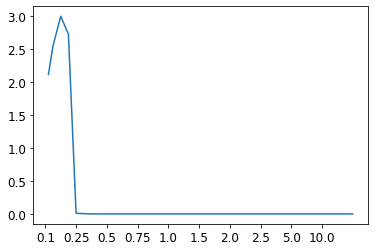

In [205]:
plt.plot(stds, diffs_passed)
plt.xticks(range(len(stds)), stds);

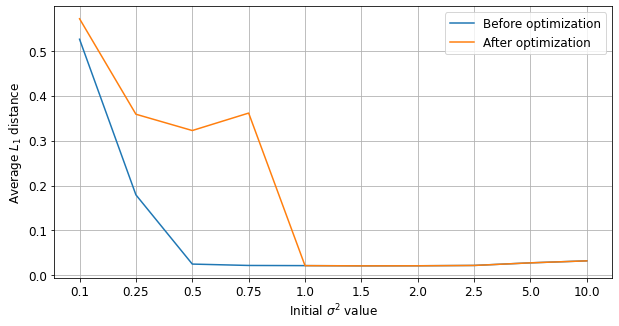

In [206]:
plt.figure(figsize=(10, 5))
plt.plot(initial_losses, label='Before optimization')
plt.plot(final_losses, label='After optimization')
plt.legend()
plt.xlabel('Initial $\sigma^2$ value')
plt.ylabel('Average $L_1$ distance')
plt.xticks(range(len(stds)), stds)
# plt.ylim(0.017, 0.02)
plt.grid();
plt.savefig(f'{save_path}/optimizing-coords.pdf', bbox_inches = 'tight', pad_inches = 0)

In [207]:
std = 2
torch.manual_seed(1)
gp = GPInterp(img.shape[1], img.shape[2], 0.2, std, 10)
gp.means.data = torch.rand_like(gp.means.data)
gp.means.data[:, 0].mul_(img.shape[2])
gp.means.data[:, 1].mul_(img.shape[1])
gp.to(device)
means_initial = gp.means.data.cpu().tolist()
#optim = torch.optim.SGD(gp.parameters(), lr=10.0, momentum=0.9)
optim = torch.optim.SGD([gp.means], lr=10.0, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.5)
grad_norms = []

for i in tqdm(range(1001)):
    out = gp(img)
    #loss = (out - img).pow(2).mean()
    loss = (out - img).abs().mean()
    if i == 0:
        initial_losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    gp.means.grad[torch.isnan(gp.means.grad)] = 0.0
    gp.stds.grad[torch.isnan(gp.stds.grad)] = 0.0
    optim.step()
    scheduler.step()
    gp.means.data[:,0].clamp_(0.0, img.shape[2])
    gp.means.data[:,1].clamp_(0.0, img.shape[1])
    
    if i % 100 == 0:
        print(loss.item())

  0%|          | 2/1001 [00:00<01:51,  8.99it/s]

0.021411051973700523


 10%|█         | 102/1001 [00:11<01:37,  9.24it/s]

0.02139521762728691


 20%|██        | 202/1001 [00:21<01:26,  9.24it/s]

0.021385734900832176


 30%|███       | 302/1001 [00:32<01:15,  9.24it/s]

0.021380715072155


 40%|████      | 402/1001 [00:43<01:04,  9.24it/s]

0.021378781646490097


 50%|█████     | 502/1001 [00:54<00:54,  9.22it/s]

0.02137834206223488


 60%|██████    | 602/1001 [01:05<00:43,  9.21it/s]

0.021378276869654655


 70%|███████   | 702/1001 [01:15<00:32,  9.24it/s]

0.021378260105848312


 80%|████████  | 802/1001 [01:26<00:21,  9.23it/s]

0.021378258243203163


 90%|█████████ | 902/1001 [01:37<00:10,  9.24it/s]

0.021378254517912865


100%|██████████| 1001/1001 [01:48<00:00,  9.24it/s]

0.021378254517912865


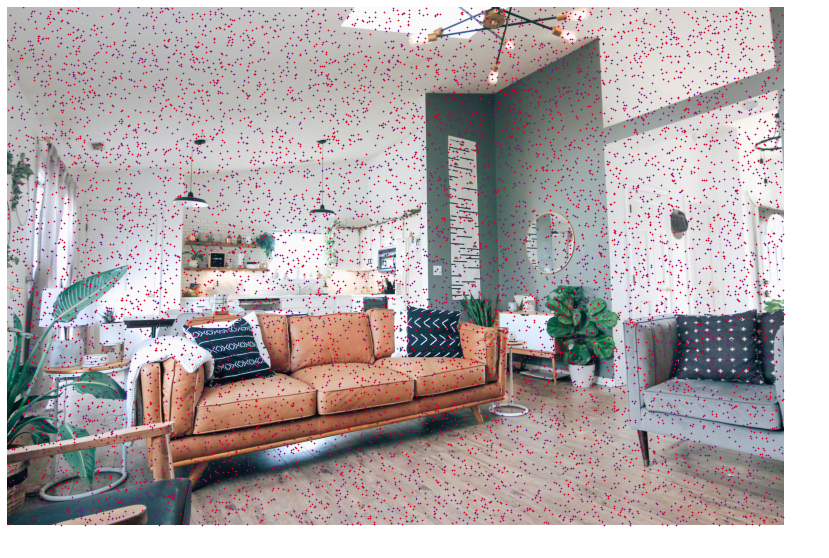

In [208]:
import random

# img_np = np.array(TVF.to_pil_image(out.cpu()))

# random_idx = random.sample(range(len(gp.means)), 1000)
# idx = range(0, len(gp.means), 4)
# downsample_factor = 0.2
# grid_h = round(img_np.shape[0] * downsample_factor)
# grid_w = round(img_np.shape[1] * downsample_factor)
# step_size = 2
# rows_idx = torch.arange(0, grid_h, step_size)
# idx = ((rows_idx * grid_w).view(-1, 1) + torch.arange(0, grid_w, step_size).view(1, -1)).view(-1)
# means_orig = GPInterp(img.shape[1], img.shape[2], 0.2, 2.0, 5).means.cpu().data
idx = random.sample(range(len(gp.means)), 10000)
img_np = np.array(img_pil)
plt.figure(figsize=(20, 10))
plt.imshow(img_np)
means_initial = torch.tensor(means_initial).data

plt.scatter(means_initial[idx, 0].clamp_(0.0, img.shape[2]), means_initial[idx, 1].clamp_(0.0, img.shape[1]), marker='o', color='blue', s=0.2)
plt.scatter(gp.means.cpu().data[idx, 0].clamp_(0.0, img.shape[2]), gp.means.cpu().data[idx, 1].clamp_(0.0, img.shape[1]), marker='o', color='red', s=0.2)
# TVF.to_pil_image(out.cpu())
plt.axis('off')
plt.savefig(f'{save_path}/coords-paths.pdf', bbox_inches = 'tight', pad_inches = 0)

In [131]:
# TVF.to_pil_image(GPInterp(img.shape[1], img.shape[2], 0.2, 1.0, 5).cuda()(img).cpu())

In [130]:
# TVF.to_pil_image(out.cpu())

In [125]:
tqdm._instances.clear()

In [130]:
import os
from tqdm import tqdm

# ds_dir = '/ibex/scratch/skoroki/datasets/imagenet/imagenet-128'
ds_dir = '/ibex/reference/CV/ILSVR/classification-localization/data/jpeg/train'
class_dirs = [os.path.join(ds_dir, d) for d in os.listdir(ds_dir)]
img_paths = [os.path.join(d, os.listdir(d)[0]) for d in class_dirs]
imgs = [Image.open(p) for p in tqdm(img_paths)]

100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


In [131]:
for downsample_factor in np.linspace(0.1, 0.5, 5):
    qualities = []
    for img_pil in tqdm(imgs):
        img = TVF.to_tensor(img_pil).to(device)
        stds_qualities = []
        for radius in [1, 2, 3, 5, 10]:
            for std in [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 5.0]:
                gp = GPInterp(img.shape[1], img.shape[2], downsample_factor, std, radius)
                gp.to(device)
                out = gp(img)
                loss = (out - img).abs().mean()
                stds_qualities.append(loss.item())
        qualities.append(np.min(stds_qualities))
    print('Avg rec quality:', np.mean(qualities))

  0%|          | 2/1000 [00:00<01:00, 16.55it/s]

Avg rec quality: 0.06290161732491106


  0%|          | 2/1000 [00:00<01:10, 14.18it/s]

Avg rec quality: 0.04523806522646919


  0%|          | 1/1000 [00:00<02:18,  7.22it/s]

Avg rec quality: 0.036586944713257255


  0%|          | 1/1000 [00:00<03:09,  5.26it/s]

Avg rec quality: 0.03053101780684665


100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


Avg rec quality: 0.025468778039794415


In [134]:
from PIL import Image
import torchvision.transforms.functional as TVF

interps = ['NEAREST', 'BOX', 'BILINEAR', 'HAMMING', 'BICUBIC', 'LANCZOS']
# img_pil = Image.open('../cuda/water.jpg')
# img_pil = Image.open('../cuda/room.jpg')
results = {}

for interp in tqdm(range(6)):
    results[interp] = []
    for downsample_factor in np.linspace(0.1, 0.5, 5):
        qualities = []
        for img_pil in imgs:
            img = TVF.to_tensor(img_pil)
            downsample_size = round(downsample_factor * img.shape[1]), round(downsample_factor * img.shape[2])
            downsampled = TVF.resize(img_pil, size=downsample_size, interpolation=2)
            upsampled = TVF.resize(downsampled, size=(img.shape[1], img.shape[2]), interpolation=interp)
            qualities.append((TVF.to_tensor(upsampled) - img).abs().mean().item())
        print(f'Avg rec quality for {interps[interp]}:', np.mean(qualities))
        results[interp].append(np.mean(qualities))

Avg rec quality for NEAREST: 0.06310559467971324
Avg rec quality for NEAREST: 0.047599796486552805
Avg rec quality for NEAREST: 0.04008128818450495
Avg rec quality for NEAREST: 0.03513761415751651
Avg rec quality for NEAREST: 0.030454675399698317
Avg rec quality for BOX: 0.05870045784022659
Avg rec quality for BOX: 0.04371110582258552
Avg rec quality for BOX: 0.03629220305243507
Avg rec quality for BOX: 0.031215432873927057
Avg rec quality for BOX: 0.027432083052117376
Avg rec quality for BILINEAR: 0.0630161278611049
Avg rec quality for BILINEAR: 0.047090807533822956
Avg rec quality for BILINEAR: 0.03940491979476064
Avg rec quality for BILINEAR: 0.03417546771792695
Avg rec quality for BILINEAR: 0.03066872836695984
Avg rec quality for HAMMING: 0.05983054078463465
Avg rec quality for HAMMING: 0.04462761883437633
Avg rec quality for HAMMING: 0.03711543625919148
Avg rec quality for HAMMING: 0.03198602318717167
Avg rec quality for HAMMING: 0.0282793346401304
Avg rec quality for BICUBIC: 0.0

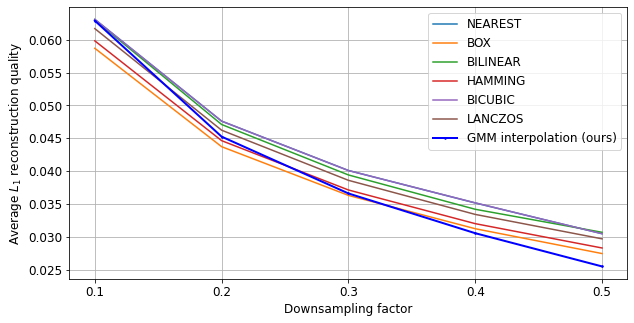

In [149]:
import matplotlib.pyplot as plt

gmm_results = [0.06290161732491106, 0.04523806522646919, 0.036586944713257255, 0.03053101780684665, 0.025468778039794415]

plt.figure(figsize=(10, 5))

for i, interp in enumerate(interps):
    plt.plot(results[i], label=interps[i])
    
plt.plot(gmm_results, label='GMM interpolation (ours)', marker='.', markersize=3, linewidth=2, color='blue')
plt.xticks(ticks=range(5), labels=[0.1, 0.2, 0.3, 0.4, 0.5])
plt.grid()
plt.xlabel('Downsampling factor')
plt.ylabel('Average $L_1$ reconstruction quality')
plt.legend();

save_path = './plots'; os.makedirs(save_path, exist_ok=True)
plt.savefig(f'{save_path}/imagenet-experiments.pdf', bbox_inches = 'tight', pad_inches = 0)